In [145]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from operator import itemgetter
from bisect import bisect_left  
from tqdm import tqdm

## Finding matches between the MSD dataset and the Billboard Hot 100 dataset

### 1. Reading the inputs

In [105]:
hot_bill = pd.read_csv("/Users/dafirebanks/Downloads/Hot Stuff.csv")

# Convert the song names and artists to lowercase to not stumble upon crazy non-matches
hot_bill["Song"] = hot_bill["Song"].apply(str.lower)
hot_bill["Performer"] = hot_bill["Performer"].apply(str.lower)

In [104]:
hot_bill.head()

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/2012-1...,12/15/2012,21,don't you worry child,swedish house mafia featuring john martin,Don't You Worry ChildSwedish House Mafia Featu...,1,28.0,21,11
1,http://www.billboard.com/charts/hot-100/2012-1...,12/22/2012,14,don't you worry child,swedish house mafia featuring john martin,Don't You Worry ChildSwedish House Mafia Featu...,1,21.0,14,12
2,http://www.billboard.com/charts/hot-100/2012-1...,12/29/2012,12,don't you worry child,swedish house mafia featuring john martin,Don't You Worry ChildSwedish House Mafia Featu...,1,14.0,12,13
3,http://www.billboard.com/charts/hot-100/2013-0...,1/5/2013,11,don't you worry child,swedish house mafia featuring john martin,Don't You Worry ChildSwedish House Mafia Featu...,1,12.0,11,14
4,http://www.billboard.com/charts/hot-100/2013-0...,1/12/2013,15,don't you worry child,swedish house mafia featuring john martin,Don't You Worry ChildSwedish House Mafia Featu...,1,11.0,11,15


In [3]:
# Get the song names from the MSD summary!
h5file = h5py.File('msd_summary_file.h5', 'r')

In [4]:
# See which keys are in the file 
# print(list(h5file.keys()))

# Getting the dataframes from each group
metadata = h5file['metadata']['songs']

# This array contains all the metadata values for each of the million songs
meta = metadata.value 

### 2. Do some filtering and cleaning of the MSD dataset

In [5]:
# Get the list of all song names and artists!
names = meta['title']
artists = meta['artist_name']

In [11]:
# We will sort the list of songs and artists for more efficient lookup
combined = zip(names, artists)

# Sort based on song name - use itemgetter for efficiency!
combined = sorted(combined, key=itemgetter(0)) 

# Make them separate lists again
unzipped = list(zip(*combined))
names = list(unzipped[0])
artists = list(unzipped[1])

In [35]:
# Check that it is sorted well!
names[15500:17510] 

[b'a knife for the girls',
 b'a knife for the ladies (1992 digital remaster)',
 b'a knife for the ladies (1997 digital remaster)',
 b'a knife in their eye',
 b'a knife to cut the cornbread',
 b'a koan from hugh',
 b'a koko',
 b'a kundi a tidarhavi',
 b'a k\xc3\xb6vetkez\xc3\xb6 buszon',
 b"a l'abri",
 b"a l'amour comme a la guerre",
 b"a l'ancienne (feat. rohff) [remix]",
 b"a l'arri\xc3\xa8re des taxis",
 b"a l'arri\xc3\xa8re des taxis",
 b"a l'arri\xc3\xa8re des taxis",
 b"a l'attaque",
 b"a l'aube d'un nouveau jour",
 b"a l'enterrement de ma grand-m\xc3\xa8re",
 b"a l'envers a l'endroit",
 b"a l'est de java",
 b"a l'est de java",
 b"a l'ombre",
 b"a l'origine",
 b"a l'eau",
 b"a l'heure o\xc3\xb9",
 b"a l'occasion tu souris",
 b"a l'ouest",
 b'a letter from grozny',
 b'a little bit more',
 b'a lot of',
 b'a lot of',
 b'a la bien',
 b'a la bien (live marseille 2007)',
 b'a la bio a la bao',
 b'a la calle',
 b'a la calle me sal\xc3\xad',
 b'a la campagne',
 b'a la casa',
 b'a la casa'

In [28]:
# We will make a dictionary of songs that have the same name and their respective indices
duplicates = defaultdict(list)
for i, e in enumerate(names):
    duplicates[e].append(i)

### 3. Perform the search

In [90]:
# To avoid adding duplicates
found_songs = set()

# Convert billboard songs to lowercase as well
hotbill_songs = [s.lower() for s in hot_bill["Song"]]
hotbill_artists = [a.lower() for a in hot_bill["Performer"]]

# We will check if any of the billboard songs is in the million songs full datasetfor i in range(len(hot_bill["Song"])):
for i in tqdm(range(len(hot_bill["Song"]))):
    song = hotbill_songs[i]
    artist = hotbill_artists[i]
        
    # Perform binary search and try to find the index if any
    # If we find a song title in the million song dataset, we will check that they have the same artist
    if bisect_left(names, song.encode("utf-8")):

        # But first, we make sure to take in account the cases where there are multiple songs with the same name
        index = duplicates[song.encode("utf-8")]
        
        # Sometimes bisect_left messes up (in our favor), which is why we gotta check if the length of the index is 0
        if len(index) != 0:
        
            # If there are, we will check each of the artists of the same-named songs for a match, 
            # else there will only be 1 iteration because the index list length is 1
            for idx in index:
                if artist.encode("utf-8") == artists[idx]:
                    found_songs.add((song, artist))

if not found_songs:
    print("Ok, I guess that none of these songs were actually popular")

100%|██████████| 315295/315295 [00:01<00:00, 161630.24it/s]


In [89]:
# These are the total matches 
len(found_songs)

7525

In [95]:
# Sample found songs
list(found_songs)[:20]

[('rocky mountain way', 'joe walsh'),
 ('happy-go-lucky-me', 'paul evans'),
 ("can't fight this feeling", 'reo speedwagon'),
 ('the world i know', 'collective soul'),
 ("i didn't want to need you", 'heart'),
 ('clap for the wolfman', 'the guess who'),
 ('dangerous', 'natalie cole'),
 ('two-bit manchild', 'neil diamond'),
 ('sound asleep', 'the turtles'),
 ("i got the feelin' (it's over)", 'gregory abbott'),
 ('sway', 'bobby rydell'),
 ("(i can't help you) i'm falling too", 'skeeter davis'),
 ('i want it that way', 'backstreet boys'),
 ('turn up the radio', 'autograph'),
 ("i'm goin' down", 'mary j. blige'),
 ('grizzly bear', 'the youngbloods'),
 ('people get ready', 'the impressions'),
 ("you don't believe", 'the alan parsons project'),
 ('free ride', 'tavares'),
 ('dreams', 'the cranberries')]

### (Sidenote) Confirm that the subset of MSD does not contain songs in the BT100 dataset

In [39]:
mill_data = pd.read_csv("/Users/dafirebanks/Documents/Spring_2019/Data Science/SongPope/SongCSV2.csv")

# We will check if any of the billboard songs is in the million songs subset of the dataset

found = False

for i in range(len(hot_bill["Song"])):
    song = hot_bill["Song"][i]
    artist = hot_bill["Performer"][i]
    
    # If we find a song title in the million song dataset, we will check that they have the same artist
    if str(song.encode("utf-8")) in list(mill_data["Title"]):
        
        # But first, we make sure to take in account the cases where there are multiple songs with the same name
        index = mill_data.index[mill_data['Title'] == str(song.encode("utf-8"))].to_list()
        
        # If there are, we will check each of the artists of the same-named songs for a match, 
        # else there will only be 1 iteration because the index list length is 1
        for idx in index:
            if artist.encode("utf-8") == mill_data["ArtistName"][idx]:
                print(f"Song is {song} ------ Artist is {artist}")
                found = True
                break
if not found:
    print("No matches between both datasets!")

No matches between both datasets!


## Preliminary analysis on the Billboard dataset using only the MSD songs found

### 1. Create subset of MSD songs in billboard

Because there are many rows in the billboard dataset that contain the same song name and artist, we will create a subset of the MSD songs that appear in the billboard dataset by by creating a list of mini dataframes that contain the rows of the songs found, and concatenating them at the end

In [116]:
df_list = []

for (s, a) in found_songs:
    
    # Get the indices in the billboard dataframe that have the corresponding song and artist
    song_indices = hot_bill[(hot_bill['Song'] == s) & (hot_bill['Performer'] == a)].index
    
    # Create a dataframe with them and append it to the dataframe list
    df_list.append(pd.DataFrame(hot_bill.iloc[song_indices]))

# Put all the minidataframes together!
bill_msd = pd.concat(df_list)

In [118]:
bill_msd.head(20)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
8226,http://www.billboard.com/charts/hot-100/1973-0...,8/18/1973,96,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,99.0,96,2
24958,http://www.billboard.com/charts/hot-100/1973-0...,9/29/1973,32,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,36.0,32,8
44540,http://www.billboard.com/charts/hot-100/1973-1...,10/6/1973,30,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,32.0,30,9
50833,http://www.billboard.com/charts/hot-100/1973-1...,10/27/1973,33,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,23.0,23,12
55386,http://www.billboard.com/charts/hot-100/1973-1...,11/3/1973,39,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,33.0,23,13
76727,http://www.billboard.com/charts/hot-100/1973-0...,8/25/1973,87,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,96.0,87,3
76976,http://www.billboard.com/charts/hot-100/1973-0...,9/8/1973,56,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,64.0,56,5
86624,http://www.billboard.com/charts/hot-100/1973-1...,10/13/1973,24,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,30.0,24,10
91998,http://www.billboard.com/charts/hot-100/1973-1...,10/20/1973,23,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,24.0,23,11
96000,http://www.billboard.com/charts/hot-100/1973-1...,11/10/1973,48,rocky mountain way,joe walsh,Rocky Mountain WayJoe Walsh,1,39.0,23,14


In [161]:
# We will create a dataframe that contains the top peak position of every song
temp_msd = bill_msd.sort_values(by='Peak Position')
result = temp_msd.drop_duplicates('Song', keep="first")
result.head(10)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
84441,http://www.billboard.com/charts/hot-100/1959-0...,5/16/1959,3,the happy organ,"dave ""baby"" cortez","The Happy OrganDave ""Baby"" Cortez",1,1.0,1,10
178207,http://www.billboard.com/charts/hot-100/2002-0...,3/2/2002,6,u got it bad,usher,U Got It BadUsher,1,3.0,1,24
282716,http://www.billboard.com/charts/hot-100/1975-0...,2/22/1975,36,mandy,barry manilow,MandyBarry Manilow,1,28.0,1,15
302230,http://www.billboard.com/charts/hot-100/2000-0...,9/23/2000,5,incomplete,sisqo,IncompleteSisqo,1,5.0,1,14
89844,http://www.billboard.com/charts/hot-100/1976-0...,6/19/1976,1,silly love songs,wings,Silly Love SongsWings,1,1.0,1,11
50720,http://www.billboard.com/charts/hot-100/1971-0...,7/17/1971,31,brown sugar,the rolling stones,Brown SugarThe Rolling Stones,1,13.0,1,12
290031,http://www.billboard.com/charts/hot-100/2001-1...,10/13/2001,1,fallin',alicia keys,Fallin'Alicia Keys,1,1.0,1,18
245189,http://www.billboard.com/charts/hot-100/1981-0...,9/12/1981,11,jessie's girl,rick springfield,Jessie's GirlRick Springfield,1,9.0,1,25
181623,http://www.billboard.com/charts/hot-100/1990-0...,9/8/1990,12,vision of love,mariah carey,Vision Of LoveMariah Carey,1,8.0,1,15
302517,http://www.billboard.com/charts/hot-100/1973-0...,7/14/1973,9,my love,paul mccartney and wings,My LovePaul McCartney And Wings,1,3.0,1,14


In [213]:
means = result.groupby("Peak Position").mean()
means.head()

,Week Position,Instance,Previous Week Position,Weeks on Chart
Peak Position,,,,
1,21.143777,1.006438,15.605150,14.815451
2,22.025381,1.010152,16.812183,16.055838
3,24.137931,1.009852,17.663366,14.428571
4,25.000000,1.030303,19.250000,14.751515
5,26.687500,1.028409,19.363636,16.079545


Text(0.5, 1.0, 'Average weeks on chart by rank')

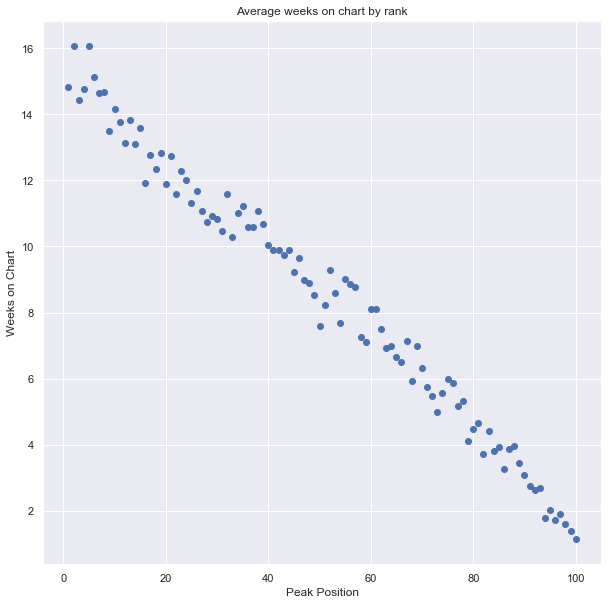

In [230]:
plt.scatter(means.index.values, means["Weeks on Chart"].values)
plt.xlabel("Peak Position")
plt.ylabel("Weeks on Chart")
plt.title("Average weeks on chart by rank")

Text(0.5, 1.0, 'Average previous position by rank')

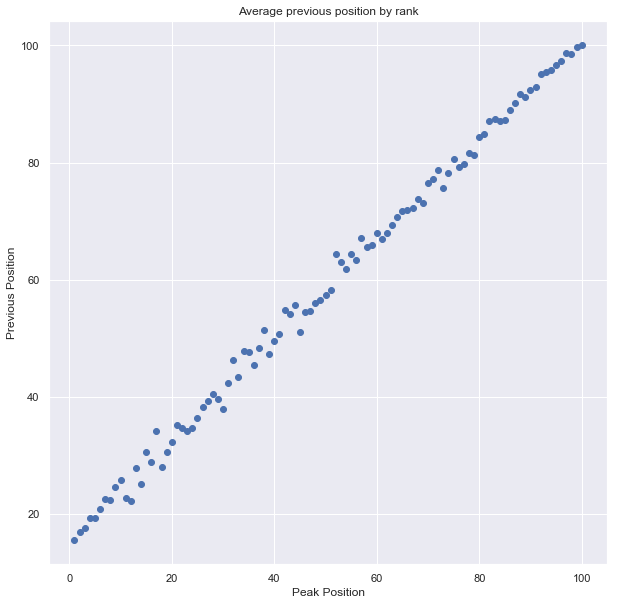

In [231]:
plt.scatter(means.index.values, means["Previous Week Position"].values)
plt.xlabel("Peak Position")
plt.ylabel("Previous Position")
plt.title("Average previous position by rank")

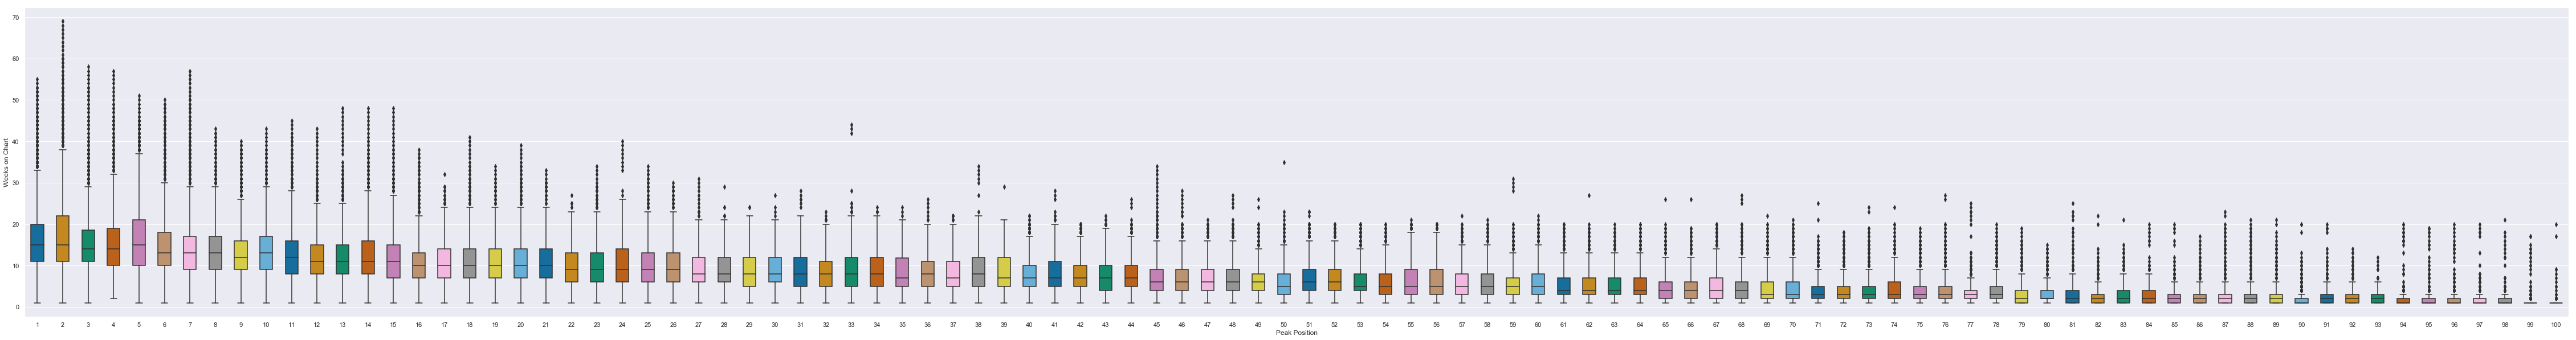

In [242]:
sns.boxplot(y='Weeks on Chart', x='Peak Position', 
                 data=bill_msd, 
                 width=0.5,
                 palette="colorblind")

sns.set(rc={'figure.figsize':(10, 60)})

In [218]:
a = list([[1, 3, 4], [5, 6, 7]])
b = np.array([[1, 3, 4], [5, 6, 7]])
stra = str(a).replace(",")

## Preliminary analysis on the MSD dataset using only the MSD songs found on the Billboard dataset

### 1. Create subset of MSD songs on the MSD

In [271]:
# Create dataFrame out of features we will use from the MSD summary
# NOTE: We can also add all of the remaining features from the summary, but for now they are not relevant. 
# Also to use for adding target variables!

artist_familiarity = meta["artist_familiarity"]
artist_hotness = meta["artist_hotttnesss"]
album = meta["release"]
bill_presence = np.zeros(1000000)

msd_df = pd.DataFrame({"Song Title": names, 
                       "Artist Name": artists, 
                       "Artist Familiarity": artist_familiarity, 
                       "Artist Hotness": artist_hotness,
                       "Album": album,
                       "Billboard Presence": bill_presence})

In [272]:
msd_df.head(20)

,Song Title,Artist Name,Artist Familiarity,Artist Hotness,Album,Billboard Presence
0,b'',b'milton',0.649822,0.394032,b'Monster Ballads X-Mas',0.0
1,b'',b's\xc3\xa9bastien roch',0.439604,0.356992,b'Karkuteill\xc3\xa4',0.0
2,b'',b's\xc3\xa9bastien roch',0.643681,0.437504,b'Butter',0.0
3,b'',b's\xc3\xa9bastien roch',0.448501,0.372349,b'De Culo',0.0
4,b'',b's\xc3\xa9bastien roch',0.000000,0.000000,b'Rene Ablaze Presents Winter Sessions',0.0
5,b'',b's\xc3\xa9bastien roch',0.361287,0.109626,b'Berwald: Symphonies Nos. 1/2/3/4',0.0
6,b'',b's\xc3\xa9bastien roch',0.692923,0.453732,b'Strictly The Best Vol. 34',0.0
7,b'',b's\xc3\xa9bastien roch',0.588156,0.401092,b'Da Bomb',0.0
8,b'',b's\xc3\xa9bastien roch',0.408465,0.285901,b'Danny Boy',0.0
9,b'',b'remute',0.419941,0.249137,b'March to cadence with the US marines',0.0


### 2. Do the search, concatenate selected, add to DF

In [283]:
# Same process as the billboard dataset 
msd_list = []
for (s, a) in found_songs:
    
    # Get the indices in the billboard dataframe that have the corresponding song and artist
    song_indices = msd_df[(msd_df['Song Title'] == s.encode("utf-8")) & (msd_df['Artist Name'] == a.encode("utf-8"))].index
    
    df_toadd = pd.DataFrame(msd_df.iloc[song_indices])
    
    # For now adds a binary label of whether the song is in the billboard list or not -> to use as target variable
    msd_df.loc[song_indices, "Billboard Presence"] = 1.0
    
    # Create a dataframe with them and append it to the dataframe list
    msd_list.append(df_toadd)

# Put all the minidataframes together!
hot_msd = pd.concat(msd_list)

In [288]:
msd_df[msd_df["Billboard Presence"] > 0.0].head() # Confirm that we have indeed added the target variable

,Song Title,Artist Name,Artist Familiarity,Artist Hotness,Album,Billboard Presence
163,b'#1',b'nelly',0.379705,0.294968,b'The Great Bouzouki / Get Up',1.0
734,"b""'til my baby comes home""",b'luther vandross',0.443115,0.107688,b'Tropical Postcards',1.0
772,"b""'til you do me right""",b'after 7',0.412867,0.238696,b'A Man And His Music - El Inolvidable',1.0
935,b'(all of a sudden) my heart sings',b'paul anka',0.670374,0.409121,b'Super Ae',1.0
939,b'(all of a sudden) my heart sings',b'mel carter',0.524747,0.359278,b'All I Hope For Christmas',1.0


Text(0.5, 1.0, 'Artist Hotness vs Artist Familiarity for Popular Songs on BT100')

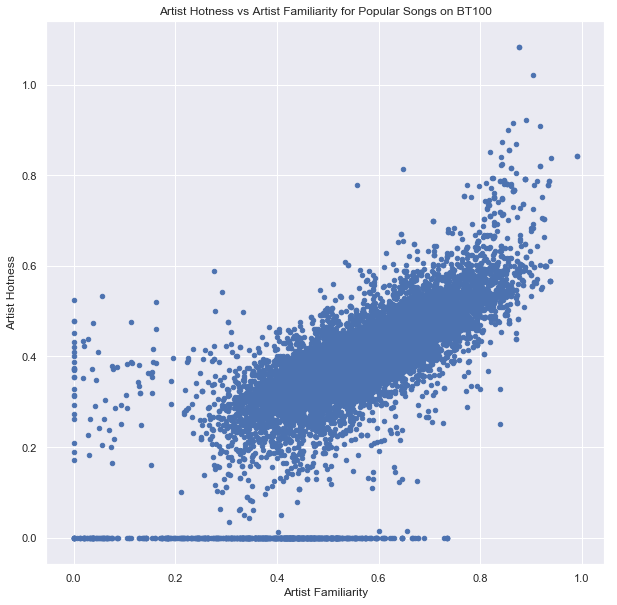

In [269]:
sns.set(rc={'figure.figsize':(10, 10)})
hot_msd.plot.scatter("Artist Familiarity", "Artist Hotness")
plt.title("Artist Hotness vs Artist Familiarity for Popular Songs on BT100")